# Latent diffusion attempt


In [ ]:
!pip install einops lpips h5py pytorch-ignite PyWavelets -q

import os
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as ttf

from lpips import LPIPS
from einops import rearrange
from h5py import File as h5File
import pywt as pywt
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 71.7 MB/s eta 0:00:00
cuda:0


### General Diffusion utils

In [ ]:
beta_min = 1e-4
beta_max = 0.02

num_steps = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

betas = np.linspace(beta_min, beta_max, num_steps)
betas = torch.from_numpy(betas).float().to(DEVICE)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
log_one_minus_alphas_cumprod = torch.log(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod - 1)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
posterior_log_variance_clipped = torch.log(posterior_variance.clamp(min=1e-20))
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
posterior_mean_coef2 = (
    (1.0 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - alphas_cumprod))

### Loss


Loss function definition:

$ J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert  \epsilon - \epsilon_{\theta}(x_t, t) \Vert^2  \ \right] $

Considering $x_{residuals} = x_{HR}- up(x_{LR})$ as $x_t$

In [ ]:
def loss_fn_cond(model, x, y):
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a
        time-dependent score-based model.
      x: A mini-batch of LR training data.
      y: Corresponding HR result.
    """
    # Estimate Residuals between LR-HR
    residuals = torch.subtract(x, y)

    # Sample time uniformly in 0, num_steps
    random_t = torch.randint(low=0, high=num_steps, size=(x.shape[0],), device=DEVICE)
    z = torch.randn_like(x)  # get normally distributed noise

    perturbed_x = (
        sqrt_alphas_cumprod[random_t][..., None, None, None] * residuals \
        + sqrt_one_minus_alphas_cumprod[random_t][..., None, None, None] * z
    )
    eps = model(perturbed_x, random_t)
    loss = torch.mean((z - eps) ** 2)
    return loss

### Time Embdedding


In [ ]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """ Args:
            x: torch.Tensor of dim 1 (e.g. torch.Tensor([12]))
        """
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps.
    Allow time repr to input additively from the side of a convolution layer.
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]
        # this broadcast the 2d tensor to 4d, add the same value across space.

---

# Data Loader


### Reading .h5 files

In [ ]:
def read_h5_temperature(filename, fillvalue=-9999, scalefactor=0.01):
    """ Return torch tensor"""
    #Open the H5 file in read mode
    with h5File(filename, 'r') as f:
        tmp = torch.Tensor(f["Temperature"]["Mean"]).unsqueeze(0)
        tmp = torch.where(tmp==fillvalue, tmp[tmp!=fillvalue].mean(), tmp)
        tmp = tmp * scalefactor
        tmp = tmp / tmp.max()
        return tmp

<ipython-input-9-a638bca0f102>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tmp = torch.Tensor(f["Temperature"]["Mean"]).unsqueeze(0)


torch.Size([4, 2, 64, 64]) torch.Size([4, 2, 64, 64])


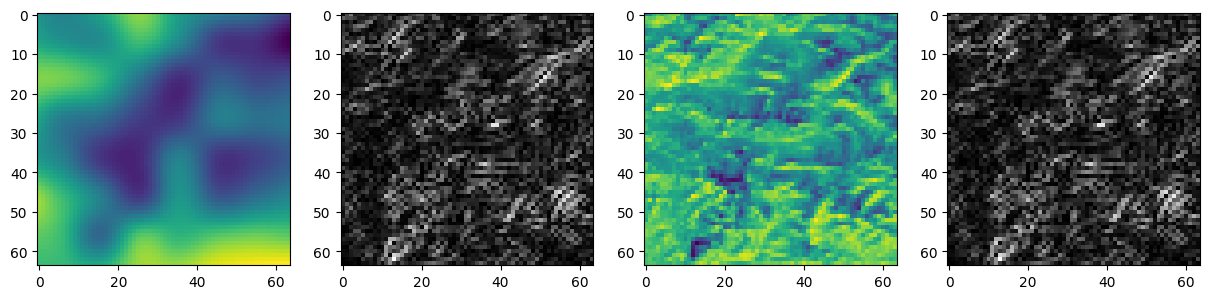

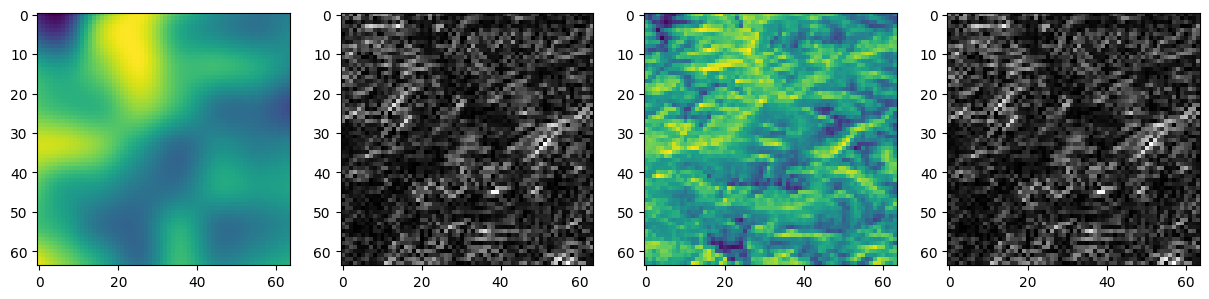

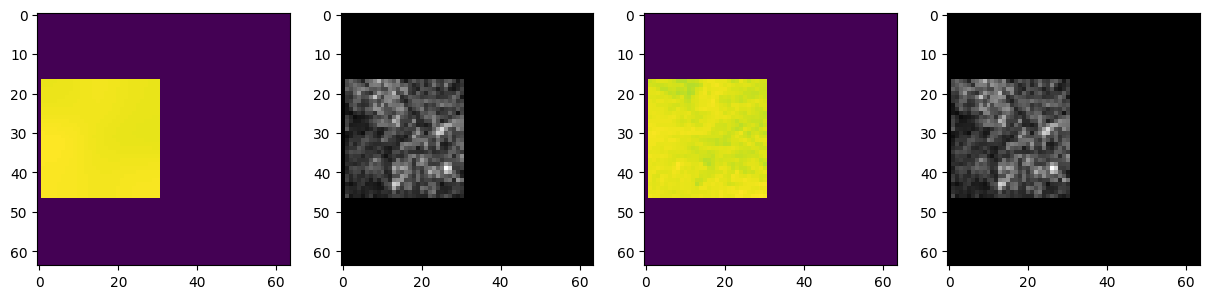

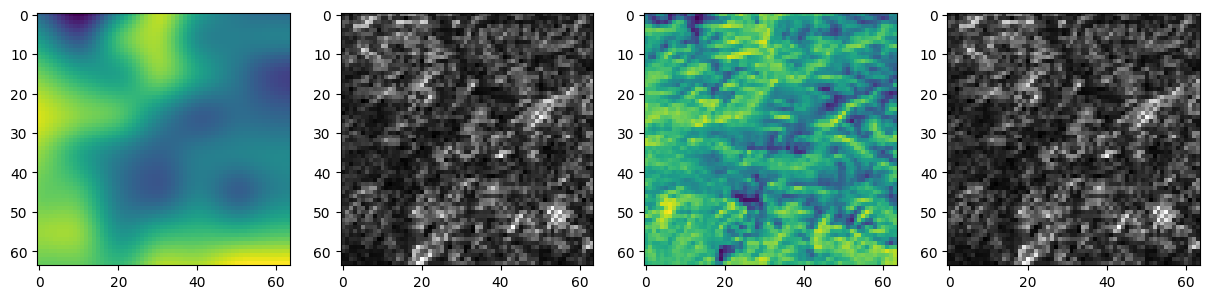

In [ ]:
class DataSamplerBatch():
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=True):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.hfimg = self.get_hf_components(self.img)
        self.merged = torch.cat([self.img, self.hfimg], 1)

        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.crop_only = crop_only

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        if self.crop_only:
            self.transform = transforms.Compose([
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True) ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                    pad_if_needed=True) ])

        self.degrees = [0., 90., 180., 270.]

    @staticmethod
    def get_hf_components(x):
        """ Args:
            x: (torch.Tensor) of dim (_, _, h, w)
        """
        _, c, h, w = x.shape
        x = F.interpolate(x, scale_factor=2, mode="bicubic", antialias=True)
        _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1])

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = F.interpolate(self.merged, scale_factor=zoom, mode="bicubic", antialias=True)
            hr_only = hr[:, 0, :, :].unsqueeze(0)
            hfmap   = hr[:, 1, :, :].unsqueeze(0)
            lr = F.interpolate(hr_only, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = F.interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            lr = torch.cat([lr, hfmap], 1)
            # Add High Frequency information
            pairs.append((hr, lr))

        return pairs

    def force_patch_size(self, tensor):
        _,_,h,w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = F.interpolate(tensor, size=target_crop, mode="nearest-exact")#, antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = [] # or torch .zeros
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                if not self.crop_only:
                    pair = self.rotate(pair)
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor



if __name__=="__main__":

    filenameLR = "AG1km.v003.45.006.0010.h5"
    filenameHR = "AG100.v003.45.006.0001.h5"
    img = read_h5_temperature(filenameLR)

    crop_size = 64
    batch_size = 4

    sampler = DataSamplerBatch(img, sr_factor=10, crop_size=crop_size,
                               batch_size=batch_size, crop_only=True)
    hr, lr = iter(sampler.generate_data()).__next__()
    print(hr.shape, lr.shape)

    for i in range(batch_size):
        _, axs = plt.subplots(1, 4, figsize=(15,8))
        axs[0].imshow(lr[i, 0, :, :].squeeze())
        axs[1].imshow(lr[i, 1, :, :].squeeze(), cmap="gray")
        axs[2].imshow(hr[i, 0, :, :].squeeze())
        axs[3].imshow(hr[i, 1, :, :].squeeze(), cmap="gray")


---

# Autoencoder




### Loss
MSE and perceptual loss

In [ ]:
class AELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss()
        self.lpips = LPIPS(net="squeeze").to(DEVICE)

    def get_lpips(self, x, xhat):
        return self.lpips(x.repeat(1,3,1,1), xhat.repeat(1,3,1,1)).mean()

    def forward(self, x, xhat):
        # Collect learnable perceptual loss for both var and HF components
        lpips_x  = self.get_lpips(x[:,0,:,:].unsqueeze(1), xhat[:,0,:,:].unsqueeze(1))
        #lpips_hf = self.get_lpips(x[:,1,:,:].unsqueeze(1), xhat[:,1,:,:].unsqueeze(1))
        return self.loss(x, xhat) + lpips_x #+ lpips_hf

def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.GELU()
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.GELU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])

    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x


class AEmodel(nn.Module):
    def __init__(self, input_channels, channels=[4,32,64], ndepth=4):
        """Args:
          channels: The number of channels for feature maps of each resolution.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        # Encoding layers where the resolution decreases
        self.encoder = nn.Sequential(
            ResBlock(input_channels, ndepth=2),
            nn.Conv2d(input_channels, channels[0], 3, stride=1, bias=False),
            nn.BatchNorm2d(channels[0]),
            nn.GELU(),

            ResBlock(channels[0], ndepth=2),
            nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False),
            nn.BatchNorm2d(channels[1]),
            nn.GELU(),

            ResBlock(channels[1], ndepth=2),
            nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False),
            nn.BatchNorm2d(channels[2]),
            nn.GELU(),

            ResBlock(channels[2], ndepth)
            )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1),
            nn.BatchNorm2d(channels[1]),
            nn.GELU(),
            nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.GELU(),
            nn.ConvTranspose2d(channels[0], input_channels, 3, stride=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


if __name__ == "__main__":
    #x = ttf.to_tensor(PIL.Image.open("alligator.jpg").convert("RGB").resize((100,100))).unsqueeze(0)
    input_channels = 1
    x = torch.rand((1, input_channels, 64, 64))
    net = AEmodel(input_channels, channels=[32,64,128], ndepth=2)
    print("input:", x.shape)
    print("encoder:", net.encoder(x).shape)
    print("decoder:",net.decoder(net.encoder(x)).shape)

input: torch.Size([1, 1, 64, 64])
encoder: torch.Size([1, 128, 14, 14])
decoder: torch.Size([1, 1, 64, 64])


### Autoencoder Training



Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/squeeze.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

  0%|          | 0/3000 [00:00<?, ?it/s]

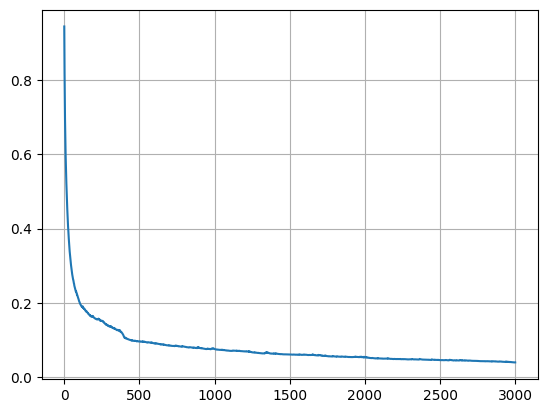

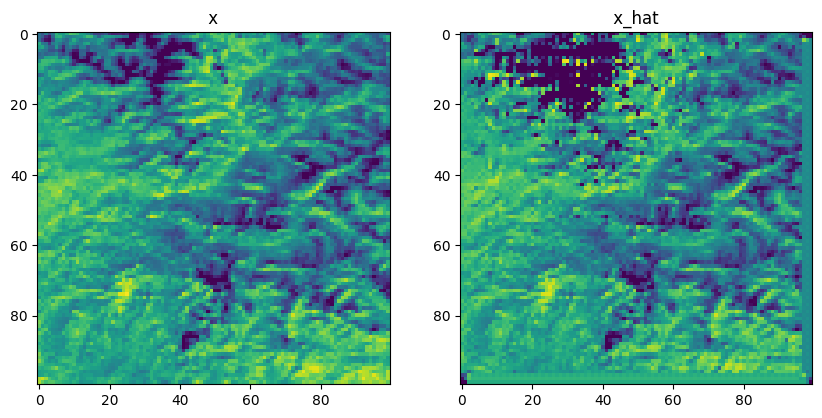

In [ ]:
nepochs       = 3000
crop_size     = 64
batch_size    = 16
learning_rate = 1e-3
new_training  = True

#sampler = DataSamplerBatch(img, sr_factor=10, crop_size=crop_size,
#                           batch_size=batch_size, crop_only=True)

loss_function = AELoss()
if new_training:
    aemodel   = AEmodel(input_channels=1, channels=[32,64,128], ndepth=4).to(DEVICE)
    optimizer = torch.optim.AdamW(aemodel.parameters(), lr=learning_rate)

adjust_learning_rate(optimizer, 1e-4)

x = img.unsqueeze(0)
x = x.to(DEVICE)

# Perform AE training
cache = np.zeros((nepochs))
aemodel.train()
progress_bar = tqdm(range(nepochs), total=nepochs)
for iteration in progress_bar:
    xhat = aemodel(x).to(DEVICE)
    loss = loss_function(x, xhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iteration % 3000 == 0:
        new_lr = learning_rate/10
        adjust_learning_rate(optimizer, new_lr)
    cache[iteration] = loss.item()
    progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{nepochs} lr: {learning_rate} Loss « {(loss.item()):.10f} »")

# Save and plot performance
torch.save(aemodel.state_dict(), "ckpt_autoencoder.pth")
plt.plot(cache); plt.grid(); plt.show()

# Plot results
nmean, nstd = x[x!=0].mean(), x[x!=0].std(),
llim, ulim  = nmean-2.5*nstd, nmean+2.5*nstd
_, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(x.detach().cpu().squeeze(), vmin=llim, vmax=ulim)
axs[0].set_title(" x ")
axs[1].imshow(xhat.detach().cpu().squeeze(), vmin=llim, vmax=ulim)
axs[1].set_title(" x_hat = D(E(x))")
plt.show()

### Autoencoder Testing



IndexError: index 1 is out of bounds for dimension 0 with size 1

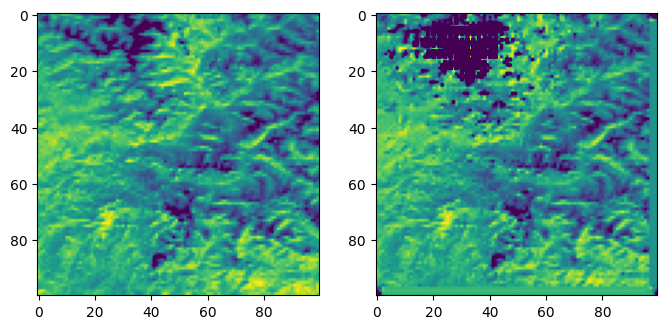

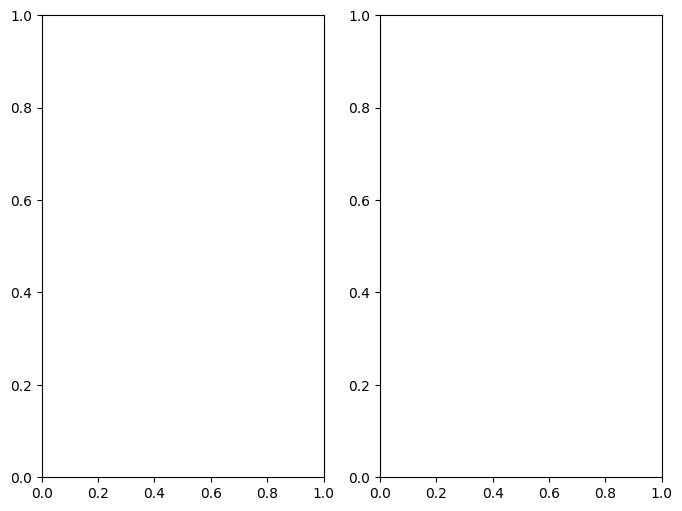

In [ ]:
newx, _ = sampler.generate_data().__next__()
newx = newx.to(DEVICE)
newx = newx[:, 0, :, :].unsqueeze(1)

aemodel.eval()
with torch.no_grad():

    z = aemodel.encoder(newx)
    x_hat = aemodel.decoder(z)

# Select only 1-st channel
newx = newx[:,0,:,:].unsqueeze(1)

nmean, nstd = newx[newx!=0].mean(), newx[newx!=0].std(),
llim, ulim  = nmean-2.5*nstd, nmean+2.5*nstd
for b in range(batch_size):
    _, axs = plt.subplots(1, 2, figsize=(8,6))
    axs[0].imshow(newx[b, :, :, :].cpu().squeeze(), vmin=llim, vmax=ulim)
    axs[1].imshow(x_hat[b, :, :, :].cpu().squeeze(), vmin=llim, vmax=ulim)

---

# Attention modules


### Channel Cross-Attention approach (1) verbose implement
Requires a joint latent representation including the climate data along with its high frequency representation to match H·W dimension at each downsampling stage.



In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.SiLU()
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.SiLU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])

    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x


class ResImgEncoder(nn.Module):
    """Simple Image encoder to be used in the Q, K, V transcription"""
    def __init__(self, nchannels, ndepth=1, nheads=1, prehead="same"):
        """ Args:
            nchannels: (int) input x_feature channel.
            ndepth: (int) amount of ResBlock with skip connection.
            nheads: (int) factor to enlarge channel dimension before crossattention.
            prehead: (str) accepted ('preupsample','postupsample', 'same')
        """
        super(ResImgEncoder, self).__init__()

        self.outchannels = nchannels * nheads

        if prehead == "preupsample":
            # move first into outchannel dim via 1x1 convblock and go on with
            # ResBlocks at outchannels
            in_c, mid_c, out_c = nchannels, self.outchannels, self.outchannels
        elif prehead == "postupsample":
            # enlarge channel dimension at the end
            in_c, mid_c, out_c = nchannels, nchannels, self.outchannels
        elif prehead == "same":
            # Preserve same dimension
            in_c, mid_c, out_c = nchannels, nchannels, nchannels
        else:
            raise ValueError("prehead values accepted : ('preupsample','postupsample', 'same')")

        self.conv1pre = nn.Conv2d(in_c, mid_c, 1, stride=1, bias=True)
        self.res_conv_blocks = ResBlock(mid_c, ndepth)
        self.conv1post = nn.Conv2d(mid_c, out_c, 1, stride=1, bias=True)

    def forward(self, x):
        x = self.conv1pre(x)
        x = self.res_conv_blocks(x)
        x = self.conv1post(x)
        return x


class ChannelAttention(nn.Module):
    """Simple Cross-attention High Frequency Guided Module"""
    def __init__(self, nchannels, ndepth=1, nheads=1, prehead="same"):
        super(ChannelAttention, self).__init__()
        self.outchannels = nchannels if prehead=="same" else nchannels * nheads
        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True
        # Convolutional encoder to process Q, K, V
        self.Q_feature_encoder = ResImgEncoder(nchannels, ndepth, nheads, prehead)
        self.K_feature_encoder = ResImgEncoder(nchannels, ndepth, nheads, prehead)
        self.V_feature_encoder = ResImgEncoder(nchannels, ndepth, nheads, prehead)
        self.crossattn_encoder = ResImgEncoder(1, ndepth, nheads=1)
        self.conv1 = nn.Conv2d(self.outchannels, nchannels, kernel_size=1, stride=1, bias=False)

    def forward(self, x):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        """
        b, _, h, w = x.shape
        c = self.outchannels
        # Generate Q,K,V via img encoder. Outshape:(batch, h*w, in_channels*nheads)
        Q = self.Q_feature_encoder(x).view(b, h*w, c)
        K = self.K_feature_encoder(x).view(b, h*w, c)
        V = self.V_feature_encoder(x).view(b, h*w, c)
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K).view(b, 1, c, c)
        scoremats = self.crossattn_encoder(scoremats).view(b, c, c)
        attnmats  = F.softmax(scoremats / torch.sqrt(self.d), dim=-1)
        # Back into batch size
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V).view(b, c, h, w)
        # 1x1 conv to convert into (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return  ctx_vecs + x


class TransformerBlock(nn.Module):
    def __init__(self, nchannels, nhidden=128, ndepth=1, nheads=1, prehead="same"):
        super().__init__()
        self.ca = ChannelAttention(nchannels, ndepth, nheads, prehead)
        self.norm1 = nn.InstanceNorm2d(nchannels)
        self.norm2 = nn.InstanceNorm2d(nchannels)
        self.mlp   = nn.Sequential(
            nn.Linear(nchannels, nhidden),
            nn.GELU(),
            nn.Linear(nhidden, nchannels),
        )
        #self.conv = nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same",
        #                      bias=True)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm1(x)
        x = self.ca(x_norm) + x
        x_norm = self.norm2(x).view(b, h*w, c)
        x = self.mlp(x_norm).view(b, c, h, w) + x
        return x


class HF_Encoder(nn.Module):
    def __init__(self, nblocks, nchannels, nhidden, ndepth=1, nheads=1,
                 prehead="same"):
        super().__init__()
        self.transformer = nn.ModuleList([
            TransformerBlock(nchannels, nhidden, ndepth, nheads, prehead)
            for _ in range(nblocks)
        ])

    def forward(self, x):
        for encode_layer in self.transformer:
            x = encode_layer(x)
        return x


if __name__ == "__main__":
    import time
    t0 = time.time()
    nchannels = 64
    x = torch.rand((1, nchannels, 64, 64))
    net = HF_Encoder(nblocks=1, nchannels=nchannels, nhidden=64,
                     ndepth=4, nheads=1, prehead="same")

    print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

    t1 = time.time()
    print(net(x).shape, t1-t0)

Learnable params: 925277
torch.Size([1, 64, 64, 64]) 0.01785135269165039


### Channel Cross-Attention approach (2)
Neglecting the squeeze part


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.SiLU()
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.SiLU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])

    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x


class ResImgEncoder(nn.Module):
    """Simple Image encoder to be used in the Q, K, V transcription"""
    def __init__(self, nchannels, ndepth=1):
        """ Args:
            nchannels: (int) input x_feature channel.
            ndepth: (int) amount of ResBlock with skip connection.
        """
        super(ResImgEncoder, self).__init__()

        self.conv1pre  = nn.Conv2d(nchannels, nchannels, 1, stride=1, bias=False)
        self.res_conv_blocks = ResBlock(nchannels, ndepth)
        self.conv1post = nn.Conv2d(nchannels, nchannels, 1, stride=1, bias=False)

    def forward(self, x):
        x = self.conv1pre(x)
        x = self.res_conv_blocks(x)
        x = self.conv1post(x)
        return x


class ChannelAttention(nn.Module):
    """Simple Cross-attention High Frequency Guided Module"""
    def __init__(self, nchannels, ndepth=1):
        super(ChannelAttention, self).__init__()
        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True
        # Convolutional encoder to process Q, K, V
        self.Q_feature_encoder = ResImgEncoder(nchannels, ndepth)
        self.K_feature_encoder = ResImgEncoder(nchannels, ndepth)
        self.V_feature_encoder = ResImgEncoder(nchannels, ndepth)
        self.crossattn_encoder = ResImgEncoder(1, ndepth)
        self.conv1 = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, bias=False)

    def forward(self, x):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        """
        b, c, h, w = x.shape
        # Generate Q,K,V via img encoder. Outshape:(batch, h*w, in_channels*nheads)
        Q = self.Q_feature_encoder(x).view(b, h*w, c)
        K = self.K_feature_encoder(x).view(b, h*w, c)
        V = self.V_feature_encoder(x).view(b, h*w, c)
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K).view(b, 1, c, c)
        scoremats = self.crossattn_encoder(scoremats).view(b, c, c)
        attnmats  = F.softmax(scoremats / torch.sqrt(self.d), dim=-1)
        # Attention map: back into batch size
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V).view(b, c, h, w)
        # 1x1 conv to convert into (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return  ctx_vecs + x


class TransformerBlock(nn.Module):
    def __init__(self, nchannels, nhidden=256, ndepth=1):
        super().__init__()
        self.ca = ChannelAttention(nchannels, ndepth)
        self.norm1 = nn.InstanceNorm2d(nchannels)
        self.norm2 = nn.InstanceNorm2d(nchannels)
        self.mlp   = nn.Sequential(
            nn.Linear(nchannels, nhidden),
            nn.GELU(),
            nn.Linear(nhidden, nchannels),
        )
        #self.conv = nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same",
        #                      bias=True)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm1(x)
        x = self.ca(x_norm) + x
        x_norm = self.norm2(x).view(b, h*w, c)
        x = self.mlp(x_norm).view(b, c, h, w) + x
        return x


class HF_Encoder(nn.Module):
    def __init__(self, nblocks, nchannels, nhidden, ndepth=1):
        super().__init__()
        self.transformer = nn.ModuleList([
            TransformerBlock(nchannels, nhidden, ndepth)
            for _ in range(nblocks)
        ])

    def forward(self, x):
        for encode_layer in self.transformer:
            x = encode_layer(x)
        return x


if __name__ == "__main__":
    import time
    t0 = time.time()

    batch_size = 1
    nchannels = 128
    imgsize = 100
    nhidden = 256
    ndepth  = 1
    nblocks = 2

    x = torch.rand((batch_size, nchannels, imgsize, imgsize))
    net = HF_Encoder(nblocks, nchannels, nhidden, ndepth)

    print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

    t1 = time.time()
    print(net(x).shape,"\nelapsed:", t1-t0)

Learnable params: 2133810
torch.Size([1, 128, 100, 100]) 
elapsed: 0.03478384017944336


### Sequence based attention implementation

In [ ]:
class ImgEncoder(nn.Module):
    """Simple Image encoder to be used in the Q, K, V transcription"""
    def __init__(self, input_channels, channels=[8,16,32]):
        super(ImgEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, channels[0], 3, stride=1, padding="same", bias=True),
            nn.BatchNorm2d(channels[0]),
            nn.MaxPool2d(2, stride=2),
            nn.SiLU(),
            nn.Conv2d(channels[0], channels[1], 3, stride=1, padding="same", bias=True),
            nn.BatchNorm2d(channels[1]),
            nn.MaxPool2d(2, stride=2),
            nn.SiLU(),
            nn.Conv2d(channels[1], channels[2], 3, stride=1, padding="same", bias=True),
            nn.BatchNorm2d(channels[2])
            )
    def forward(self, x):
        """ outdim: [b, channels[-1], H/4, W/4] """
        x = self.encoder(x)
        return x # reduced H_{out} = H/4


class CrossAttention(nn.Module):
    """Simple Cross-attention High Frequency Guided Module"""
    def __init__(self, in_channel, feature_dim, hidden_dim=256, out_dim=256):
        super(CrossAttention, self).__init__()
        self.hidden_dim  = hidden_dim
        self.h, self.w = feature_dim

        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True

        # Convolutional encoder to process Q, K, V
        self.HF_encoder   = SimpleEncoder(in_channel)
        self.feat_encoder = SimpleEncoder(in_channel)
        self.linear = nn.Sequential(
            nn.Linear(self.h//4*self.w//4, hidden_dim, bias=True),
            nn.GELU,
            nn.Linear(hidden_dim, out_dim)
            )

    def forward(self, x, orig_hf):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, _, h, w = x.shape
        # tokens: with shape (batch, h*w, hdim)
        Q = self.convHF(orig_hf).view(b, h*w, self.hidden_dim)
        Q = self.linear(Q).view(b, )

        K = self.convK(x).view(b, h*w, self.hidden_dim)
        V = self.convV(x).view(b, h*w, self.hidden_dim)

        #scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # inner product of Q and K, a tensor
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K)\
                    .view(b, 1, self.hidden_dim, self.hidden_dim)
        scoremats = self.convA(scoremats)\
                    .view(b, self.hidden_dim, self.hidden_dim)
        attnmats  = F.softmax(scoremats / torch.sqrt(self.d), dim=-1)
        #ctx_vecs  = torch.einsum("BTS,BSH->BTH", attnmats, V)
        # To (batch, hdim, h, w)
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V)\
                    .view(b, self.hidden_dim, h, w)
        # 1k conv to (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return x + ctx_vecs


class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn and feed forward neural net"""

    def __init__(self, in_channel, hidden_dim):# context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(in_channel, hidden_dim)
        #self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim),
        )

    def forward(self, x, orig_hf):#, context=None):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        # Notice the + x as residue connections
        x = self.attn_self(self.norm1(x), orig_hf) + x
        # Notice the + x as residue connections
        #x = self.attn_cross(self.norm2(x), context=context) + x
        # Notice the + x as residue connections
        x = self.ffn(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    def __init__(self, in_channel, hidden_dim):
        super(SpatialTransformer, self).__init__()
        self.hf_encoder  = ImgEncoder(1, channels=[8,16,32])
        self.img_encoder = ImgEncoder(in_channel, channels=[8,16,32])

        self.transformer = TransformerBlock(in_channel, hidden_dim)

    def forward(self, x, orig_hf):# context=None):
        b, c, h, w = x.shape
        x_in = x
        # Combine the spatial dimensions and move the channel dimen to the end
        x = rearrange(x, "b c h w->b (h w) c")
        # Apply the sequence transformer
        x = self.transformer(x, orig_hf)
        # Reverse the process
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        # Residue
        return x + x_in

### Fully working Cross Attention mechanism with images

In [ ]:
class CrossAttention(nn.Module):
    """Simple Cross-attention High Frequency Guided Module"""
    def __init__(self, in_channel, hidden_dim=128):
        super(CrossAttention, self).__init__()
        self.hidden_dim  = hidden_dim
        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True

        # Convolutional encoder to process Q, K, V
        self.convHF = nn.Conv2d(1, hidden_dim, 3, 1, "same", bias=False)
        self.convK  = nn.Conv2d(in_channel, hidden_dim, 3, 1, "same", bias=False)
        self.convV  = nn.Conv2d(in_channel, hidden_dim, 3, 1, "same", bias=False)
        self.convA  = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding="same", bias=False)
        self.conv1  = nn.Conv2d(hidden_dim, in_channel, 1, bias=False)

    def forward(self, x, orig_hf):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, _, h, w = x.shape
        # tokens: with shape (batch, h*w, hdim)
        Q = self.convHF(orig_hf).view(b, h*w, self.hidden_dim)
        K = self.convK(x).view(b, h*w, self.hidden_dim)
        V = self.convV(x).view(b, h*w, self.hidden_dim)


        #scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # inner product of Q and K, a tensor
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K)\
                    .view(b, 1, self.hidden_dim, self.hidden_dim)
        scoremats = self.convA(scoremats)\
                    .view(b, self.hidden_dim, self.hidden_dim)
        attnmats  = F.softmax(scoremats / torch.sqrt(self.d), dim=-1)
        #ctx_vecs  = torch.einsum("BTS,BSH->BTH", attnmats, V)
        # To (batch, hdim, h, w)
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V)\
                    .view(b, self.hidden_dim, h, w)
        # 1k conv to (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return x + ctx_vecs


class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn and feed forward neural net"""

    def __init__(self, in_channel, hidden_dim):# context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(in_channel, hidden_dim)
        #self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim),
        )

    def forward(self, x, orig_hf):#, context=None):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        # Notice the + x as residue connections
        x = self.attn_self(self.norm1(x), orig_hf) + x
        # Notice the + x as residue connections
        #x = self.attn_cross(self.norm2(x), context=context) + x
        # Notice the + x as residue connections
        x = self.ffn(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    def __init__(self, in_channel, hidden_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(in_channel, hidden_dim)

    def forward(self, x, orig_hf):# context=None):
        b, c, h, w = x.shape
        x_in = x
        # Combine the spatial dimensions and move the channel dimen to the end
        x = rearrange(x, "b c h w->b (h w) c")
        # Apply the sequence transformer
        x = self.transformer(x, orig_hf)
        # Reverse the process
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        # Residue
        return x + x_in

if __name__=="__main__":
    in_channel = 1
    hidden_dim = 64
    ca = CrossAttention(in_channel, hidden_dim)
    x = torch.rand((4, in_channel, 64, 64))
    orig_hf = torch.rand((4, 1, 64, 64))

    out = ca(x,orig_hf)
    conv1 = nn.Conv2d(hidden_dim, 1, 1, bias=False)

    #tb = TransformerBlock(in_channel, hidden_dim)
    #norm = nn.LayerNorm(hidden_dim)
    #print(norm(x).shape)
    print("CrossAtt output", out.shape)
    #print("Transfb output:", tb(x, orig_hf).shape)


CrossAtt output torch.Size([4, 1, 64, 64])


### Orig implementation

In [ ]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        context_dim=None,
        num_heads=1,
    ):
        """
        Note: For simplicity reason, we just implemented 1-head attention.
        Feel free to implement multi-head attention! with fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)  ###########
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)  #############
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)  ############

    def forward(self, tokens, context=None):
        # tokens: with shape [batch, sequence_len, hidden_dim]
        # context: with shape [batch, contex_seq_len, context_dim]
        if self.self_attn:
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # implement Q, K, V for the Cross attention
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)
        # print(Q.shape, K.shape, V.shape)
        scoremats = torch.einsum(
            "BTH,BSH->BTS", Q, K
        )  # inner product of Q and K, a tensor
        attnmats = F.softmax(
            scoremats / np.sqrt(self.embed_dim), dim=-1
        )  # softmax of scoremats
        # print(scoremats.shape, attnmats.shape, )
        ctx_vecs = torch.einsum(
            "BTS,BSH->BTH", attnmats, V
        )  # weighted average value vectors by attnmats
        return ctx_vecs


class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn and feed forward neural net"""

    def __init__(self, hidden_dim, context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(
            hidden_dim,
            hidden_dim,
        )
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim),
        )

    def forward(self, x, context=None):
        # Notice the + x as residue connections
        x = self.attn_self(self.norm1(x)) + x
        # Notice the + x as residue connections
        x = self.attn_cross(self.norm2(x), context=context) + x
        # Notice the + x as residue connections
        x = self.ffn(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x
        # Combine the spatial dimensions and move the channel dimen to the end
        x = rearrange(x, "b c h w->b (h w) c")
        # Apply the sequence transformer
        x = self.transformer(x, context)
        # Reverse the process
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        # Residue
        return x + x_in

# Diffusion model (Latent)


### Original Implementation

In [ ]:
class Latent_UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, channels=[4, 64, 128, 256], embed_dim=256, text_dim=256,
                 nblocks=1, ndepth=1):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1  = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[1])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])

        self.conv2  = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[2])
        self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
        self.attn2  = HF_Encoder(nblocks, channels[2], text_dim, ndepth)

        self.conv3  = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[3])
        self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])
        self.attn3  = HF_Encoder(nblocks, channels[3], text_dim, ndepth)

        self.tconv3  = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense6  = Dense(embed_dim, channels[2])
        self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
        self.attn6   = HF_Encoder(nblocks, channels[2], text_dim, ndepth)

        self.tconv2  = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)  # + channels[2]
        self.dense7  = Dense(embed_dim, channels[1])
        self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
        self.tconv1  = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1)  # + channels[1]

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        #self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        # Encoding path
        ## Incorporate information from t
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h2 = self.attn2(h2)

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3)

        # Decoding path
        ## Skip connection from the encoding path
        h = self.tconv3(h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.attn6(h)
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        return h


### Adaping attention

In [ ]:
### Adapting attention
class Latent_UNet_Tranformer(nn.Module):
    """ Needs to be better implemented !!!! """
    def __init__(self, nchannels, channels=[64, 128, 256], embed_dim=256, text_dim=256,
                 nblocks=1, ndepth=1):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        channels = [nchannels] + channels
        self.conv1  = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
        self.mpool  = nn.MaxPool2d(2, stride=2)
        self.dense1 = Dense(embed_dim, channels[1])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
        self.attn1  = HF_Encoder(nblocks, channels[1], text_dim, ndepth)

        self.conv2  = nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[2])
        self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
        self.attn2  = HF_Encoder(nblocks, channels[2], text_dim, ndepth)

        self.conv3  = nn.Conv2d(channels[2], channels[3], 3, stride=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[3])
        self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])
        #self.attn3  = HF_Encoder(nblocks, channels[3], text_dim, ndepth)

        # middle resnet block like ResUNet preserving channel dim

        self.tconv3  = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=1, bias=False)
        self.tmpool  = nn.MaxUnpool2d(2, stride=2)
        self.dense6  = Dense(embed_dim, channels[2])
        self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
        #self.attn6   = HF_Encoder(nblocks, channels[2], text_dim, ndepth)

        self.tconv2  = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=False)  # + channels[2]
        self.dense7  = Dense(embed_dim, channels[1])
        self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])

        self.tconv1  = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1)  # + channels[1]

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        #self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t):
        """ Output must be integrated with residuals """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        a1 = self.attn1(h1)

        #h1 = self.mpool(h1)
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        a2 = self.attn2(h2)

        #h2 = self.mpool(h2)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))

        # Decoding path
        ## Skip connection from the encoding path
        h = self.tconv3(h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        #h = self.attn6(h)
        h = self.tconv2(h + a2) + self.dense7(embed)
        h = h + a1
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + a1)
        # Residual adding
        return h

if __name__=="__main__":

    net = Latent_UNet_Tranformer(nchannels=2)
    x = torch.rand((1, 2, 64, 64))
    random_t = torch.randint(low=0, high=num_steps, size=(x.shape[0],), device=DEVICE)

    print(f"orig shape: {x.shape}, \nf(x) shape: {net(x, random_t).shape}")


orig shape: torch.Size([1, 2, 64, 64]), 
f(x) shape: torch.Size([1, 2, 64, 64])


### Diffusion Training

In [ ]:
# title Training Latent diffusion model

continue_training = False  # param {type:"boolean"}
if not continue_training:
    print("initilize new score model...")
    latent_score_model = torch.nn.DataParallel(
        Latent_UNet_Tranformer(
            channels=[4, 16, 32, 64],
        )
    )
    latent_score_model = latent_score_model.to(DEVICE)


nepochs = 10  # param {'type':'integer'}
batch_size = 16  # param {'type':'integer'}
lr = 1e-4  # param {'type':'number'}

# Load sampler
sampler = DataSamplerBatch(img, sr_factor=10, crop_size=crop_size, batch_size=batch_size)

# Load AutoEncoder
aemodel.eval()

latent_score_model.train()

# Model Specs
optimizer = Adam(latent_score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995**epoch))
progress_bar = tqdm(range(nepochs), total=nepochs)

for epoch in progress_bar:

    hr, lr = sampler.generate_data().__next__()
    z_hr = aemodel.encoder(hr.to(DEVICE))
    z_lr = aemodel.encoder(lr.to(DEVICE))
    loss = loss_fn_cond(latent_score_model, z_lr, z_hr) # check

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step() # !!! go on from here !!!
    lr_current = scheduler.get_last_lr()[0]
    print(
        "{} Average Loss: {:5f} lr {:.1e}".format(
            epoch, avg_loss / num_items, lr_current
        )
    )
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(latent_score_model.state_dict(), "ckpt_latent_diff_transformer.pth")